This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

### Processing words as a sequence: The sequence model approach

#### A first practical example

**Downloading the data**

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  2375k      0  0:00:34  0:00:34 --:--:-- 6582k


**Preparing the data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [3]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**A sequence model built on one-hot encoded vector sequences**

In [4]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
from tensorflow.keras.layers import Embedding

# Replace one-hot encoding with an Embedding layer
embedding_layer = Embedding(input_dim=max_tokens, output_dim=128)  # Set your desired embedding dimension
embedded = embedding_layer(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

**Training a first basic sequence model**

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.6176 - loss: 0.6295 - val_accuracy: 0.8142 - val_loss: 0.4141
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8333 - loss: 0.4036 - val_accuracy: 0.8454 - val_loss: 0.3648
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8696 - loss: 0.3273 - val_accuracy: 0.8108 - val_loss: 0.4615
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8882 - loss: 0.2886 - val_accuracy: 0.8292 - val_loss: 0.4143
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9053 - loss: 0.2527 - val_accuracy: 0.8498 - val_loss: 0.4029
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9196 - loss: 0.2172 - val_accuracy: 0.8426 - val_loss: 0.4078
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9350 - loss: 0.1827 - val_accuracy: 0.8368 - val_loss: 0.4515
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9455 - loss: 0.1550 - 

#### Learning word embeddings with the Embedding layer

**Instantiating an `Embedding` layer**

In [6]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

**Model that uses an `Embedding` layer trained from scratch**

In [7]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6250 - loss: 0.6263 - val_accuracy: 0.8106 - val_loss: 0.4273
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8216 - loss: 0.4196 - val_accuracy: 0.8184 - val_loss: 0.4116
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8656 - loss: 0.3391 - val_accuracy: 0.8412 - val_loss: 0.3962
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8899 - loss: 0.2881 - val_accuracy: 0.8560 - val_loss: 0.3781
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9080 - loss: 0.2461 - val_accuracy: 0.8512 - val_loss: 0.4007
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9240 - loss: 0.2105 - val_accuracy: 0.8492 - val_loss: 0.4120
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9416 - loss: 0.1652 - val_accuracy: 0.8504 - val_loss: 0.4704
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9550 - loss: 0.1316 - 

#### Understanding padding and masking

**Using an `Embedding` layer with masking enabled**

In [8]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6575 - loss: 0.5935 - val_accuracy: 0.8416 - val_loss: 0.3688
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8428 - loss: 0.3751 - val_accuracy: 0.8456 - val_loss: 0.3566
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8766 - loss: 0.3048 - val_accuracy: 0.8460 - val_loss: 0.3515
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9057 - loss: 0.2479 - val_accuracy: 0.8318 - val_loss: 0.4014
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9194 - loss: 0.2059 - val_accuracy: 0.8408 - val_loss: 0.4138
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9408 - loss: 0.1645 - val_accuracy: 0.8368 - val_loss: 0.5192
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9548 - loss: 0.1298 - val_accuracy: 0.8380 - val_loss: 0.5486
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9704 - loss: 0.0895 - 

#### Using pretrained word embeddings

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-25 18:41:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-25 18:41:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-25 18:41:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing the GloVe word-embeddings file**

In [10]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [11]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [13]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6214 - loss: 0.6402 - val_accuracy: 0.7740 - val_loss: 0.4813
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7678 - loss: 0.4886 - val_accuracy: 0.7738 - val_loss: 0.4759
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7931 - loss: 0.4463 - val_accuracy: 0.8028 - val_loss: 0.4234
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8125 - loss: 0.4198 - val_accuracy: 0.7770 - val_loss: 0.4628
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8202 - loss: 0.3969 - val_accuracy: 0.8036 - val_loss: 0.4328
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.8327 - loss: 0.3765 - val_accuracy: 0.8288 - val_loss: 0.3822
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8439 - loss: 0.3608 - val_accuracy: 0.8302 - val_loss: 0.3826
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.8531 - loss: 0.3444 - 

In [15]:
from tensorflow.keras import layers

# Configuration for text vectorization
max_length = 150  # Truncate reviews after 150 words
max_tokens = 10000  # Consider only the top 10,000 words

# Set up TextVectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

# Convert datasets to integer sequences
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)


In [16]:
import numpy as np

# Pretrained GloVe embeddings
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = 100  # Dimension of GloVe embeddings
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i >= max_tokens:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [24]:
# Prepare variable training sample sizes
sample_sizes = [100, 200, 300, 400, 500]

# Loop through sample sizes and evaluate models
for num_samples in sample_sizes:
    print(f"\nEvaluating with {num_samples} training samples...\n")

    # Restrict training dataset to the current sample size
    limited_train_ds = int_train_ds.take(num_samples)





Evaluating with 100 training samples...


Evaluating with 200 training samples...


Evaluating with 300 training samples...


Evaluating with 400 training samples...


Evaluating with 500 training samples...



In [25]:
# Prepare variable training sample sizes
sample_sizes = [100, 200, 300, 400, 500]

# Dictionaries to store results for both models
results_custom = {}
results_glove = {}

# Loop through sample sizes and evaluate models
for num_samples in sample_sizes:
    print(f"\nEvaluating with {num_samples} training samples...\n")

    # Restrict training dataset to the current sample size
    limited_train_ds = int_train_ds.take(num_samples)

    # Model with custom embedding layer
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded_custom = layers.Embedding(
        input_dim=max_tokens, output_dim=256
    )(inputs)  # Custom embedding layer
    x_custom = layers.Bidirectional(layers.LSTM(32))(embedded_custom)
    x_custom = layers.Dropout(0.5)(x_custom)
    outputs_custom = layers.Dense(1, activation="sigmoid")(x_custom)
    model_custom = keras.Model(inputs, outputs_custom)
    model_custom.compile(
        optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]
    )
    model_custom.fit(limited_train_ds, validation_data=int_val_ds, epochs=10)
    test_loss_custom, test_acc_custom = model_custom.evaluate(int_test_ds)
    results_custom[num_samples] = test_acc_custom  # Store accuracy
    print(f"Custom Embedding - Training Samples: {num_samples} | Test Accuracy: {test_acc_custom:.3f}")


Evaluating with 100 training samples...

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5236 - loss: 0.6930 - val_accuracy: 0.5464 - val_loss: 0.6810
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6241 - loss: 0.6459 - val_accuracy: 0.7368 - val_loss: 0.5456
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7762 - loss: 0.4976 - val_accuracy: 0.7752 - val_loss: 0.5021
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8384 - loss: 0.3971 - val_accuracy: 0.7474 - val_loss: 0.5273
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8766 - loss: 0.3135 - val_accuracy: 0.7932 - val_loss: 0.4650
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9081 - loss: 0.2509 - val_accuracy: 0.6682 - val_loss: 0.8235
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9167 - loss: 0.2162 - val_accuracy: 0.6902 - val_loss: 0.7970
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - 

In [51]:
results_glove = {}  # Dictionary to store accuracy for different sample sizes

sample_sizes = [100, 200, 300, 400, 500]  # Different training sample sizes
for num_samples in sample_sizes:
    # Slice the datasets to the current number of training samples
    train_subset = limited_train_ds.take(num_samples)  # Adjust according to your dataset structure
    val_subset = int_val_ds  # Validation set stays constant for all sample sizes

    # Rebuild the model to ensure it’s not carrying over any previous training state
    embedded_glove = layers.Embedding(
        input_dim=max_tokens,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
    )(inputs)  # Using pretrained GloVe embeddings

    x_glove = layers.Bidirectional(layers.LSTM(32))(embedded_glove)
    x_glove = layers.Dropout(0.5)(x_glove)
    outputs_glove = layers.Dense(1, activation="sigmoid")(x_glove)

    model_glove = keras.Model(inputs, outputs_glove)

    model_glove.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model on the current subset of training data
    model_glove.fit(train_subset, validation_data=val_subset, epochs=10)

    # Evaluate the model on the test dataset
    test_loss_glove, test_acc_glove = model_glove.evaluate(int_test_ds)

    # Store accuracy for the current sample size
    results_glove[num_samples] = test_acc_glove

    print(f"Pretrained GloVe Embedding - Training Samples: {num_samples} | Test Accuracy: {test_acc_glove:.3f}")

# Print all results
print("\nSummary of Results:")

print("\nPretrained GloVe Embedding Accuracies:")
for num_samples, acc in results_glove.items():
    print(f"Training Samples: {num_samples} | Test Accuracy: {acc:.3f}")


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5179 - loss: 0.7076 - val_accuracy: 0.5590 - val_loss: 0.6783
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5843 - loss: 0.6701 - val_accuracy: 0.6306 - val_loss: 0.6492
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6617 - loss: 0.6197 - val_accuracy: 0.6556 - val_loss: 0.6260
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6991 - loss: 0.5828 - val_accuracy: 0.6958 - val_loss: 0.5700
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7160 - loss: 0.5642 - val_accuracy: 0.7464 - val_loss: 0.5147
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7506 - loss: 0.5274 - val_accuracy: 0.7434 - val_loss: 0.5188
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7662 - loss: 0.4953 - val_accuracy: 0.7442 - val_loss: 0.5177
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7697 - loss: 0.4884 - val_accu

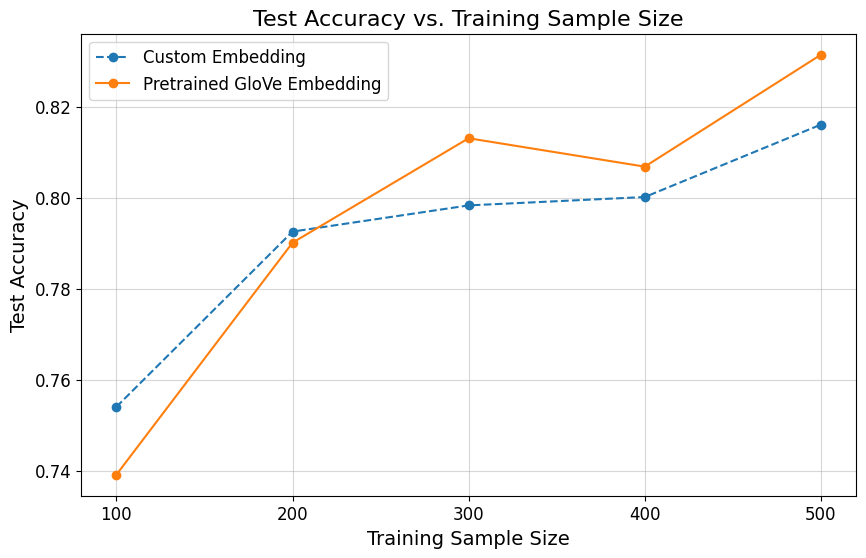

In [53]:
import matplotlib.pyplot as plt

# Sample sizes and their corresponding accuracies
sample_sizes = list(results_custom.keys())  # Training sample sizes
custom_accuracies = list(results_custom.values())  # Custom embedding accuracies
glove_accuracies = list(results_glove.values())  # Pretrained GloVe accuracies

# Plotting the accuracies
plt.figure(figsize=(10, 6))

# Plot custom embedding accuracies
plt.plot(sample_sizes, custom_accuracies, label="Custom Embedding", marker="o", linestyle="--")

# Plot pretrained GloVe accuracies
plt.plot(sample_sizes, glove_accuracies, label="Pretrained GloVe Embedding", marker="o", linestyle="-")

# Add labels, title, and legend
plt.title("Test Accuracy vs. Training Sample Size", fontsize=16)
plt.xlabel("Training Sample Size", fontsize=14)
plt.ylabel("Test Accuracy", fontsize=14)
plt.xticks(sample_sizes, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.show()
